<a href="https://colab.research.google.com/github/LohithVarun/Text_Summarization/blob/main/JournalPaperSummarization_Llama_Phi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rouge-score sentence-transformers

In [ ]:
# Install required packages
!pip install -q unsloth
!pip install -q transformers
!pip install -q accelerate
!pip install -q matplotlib
!pip install -q torch
!pip install -q PyPDF2
!pip install -q google.colab
!pip install sentence-transformers
!pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

In [ ]:
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')

Welcome to Journal Paper Summarization Analysis: LLaMA vs Phi-3 Comparison
Please upload your research paper PDF file...


Saving pls_work.pdf to pls_work (1).pdf

Successfully read PDF file: pls_work (1).pdf
Total characters: 82236

Initializing models and generating summaries. This may take a few minutes...
CUDA available: True
CUDA device: Tesla T4
CUDA memory allocated: 0.01 GB
CUDA memory reserved: 0.04 GB

--- VERIFYING MODEL INITIALIZATION ---
Loading unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit with Unsloth...
Error initializing model unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit with Unsloth: name 'time' is not defined
Attempting to use HuggingFace transformers instead...


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Successfully loaded unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit using transformers

--- INITIALIZING META AI LLAMA MODEL ---
Loading unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit with Unsloth...
Error initializing model unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit with Unsloth: name 'time' is not defined
Attempting to use HuggingFace transformers instead...


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Successfully loaded unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit using transformers

Processing 14 text chunks for evaluation...


Evaluating unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit: 3it [01:10, 23.66s/it]



--- INITIALIZING PHI-3 MODEL ---
Loading unsloth/Phi-3-mini-4k-instruct with Unsloth...
Error initializing model unsloth/Phi-3-mini-4k-instruct with Unsloth: name 'time' is not defined
Attempting to use HuggingFace transformers instead...


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Successfully loaded unsloth/Phi-3-mini-4k-instruct using transformers

Processing 14 text chunks for evaluation...


Evaluating unsloth/Phi-3-mini-4k-instruct: 3it [00:38, 12.86s/it]



FINAL EVALUATION RESULTS

Meta LLaMA Model Scores:
ROUGE-1: 0.147
ROUGE-2: 0.076
ROUGE-L: 0.122
Average: 0.115

Phi-3-Mini-4k Model Scores:
ROUGE-1: 0.064
ROUGE-2: 0.015
ROUGE-L: 0.040
Average: 0.040

LLaMA outperforms Phi-3 by 189.4% on average ROUGE score

Generating comparison plots...


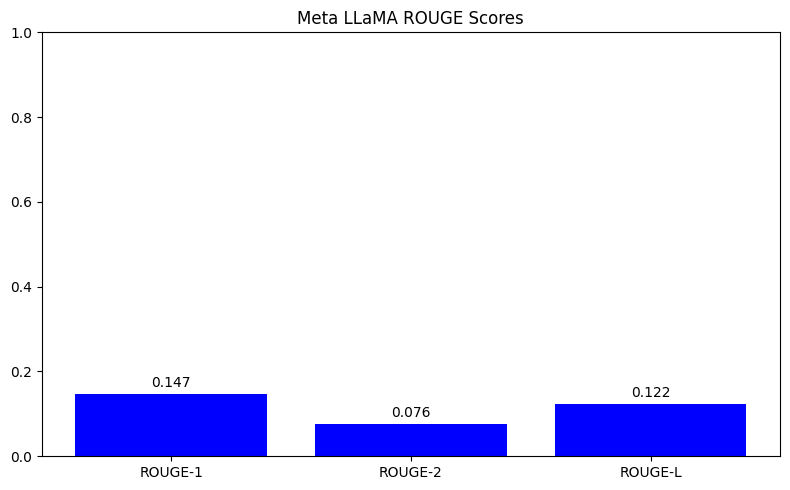

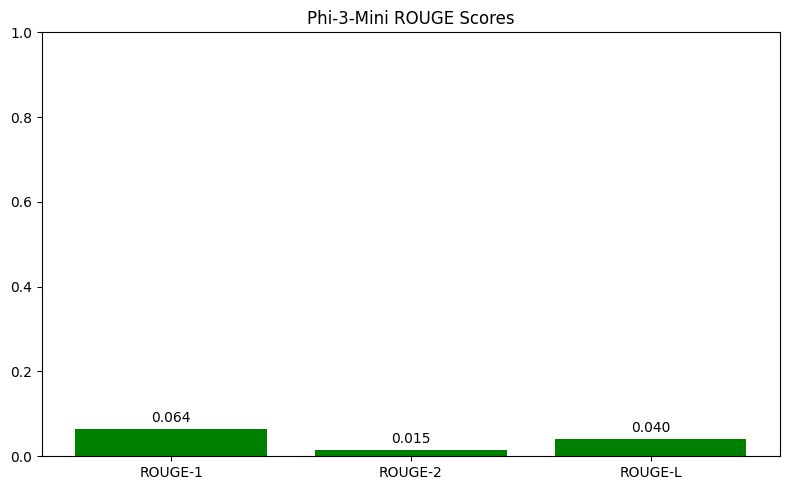

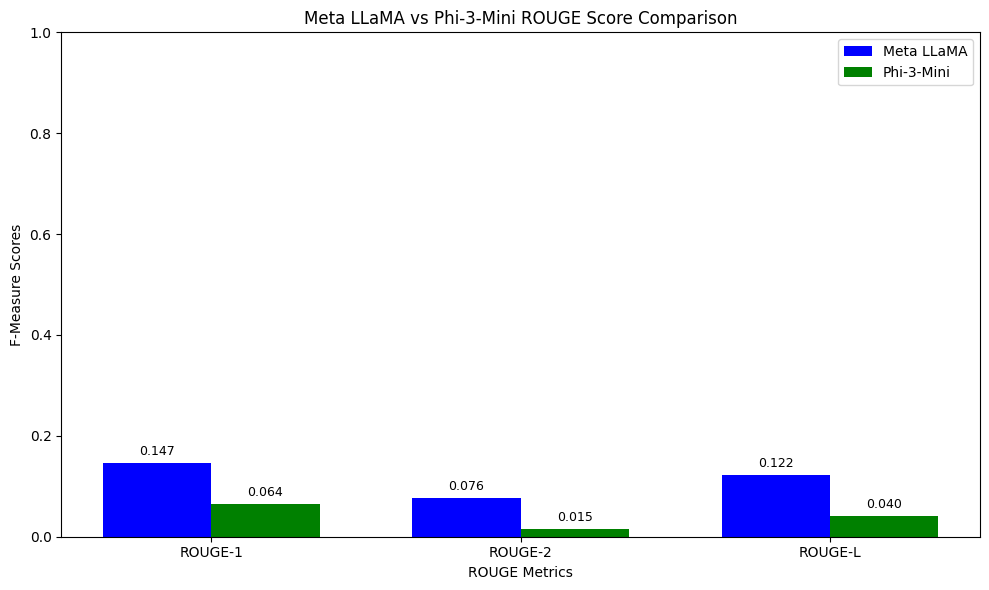


Analysis complete! Thank you for using the Journal Paper Summarization Analyzer.


In [2]:
from unsloth import FastLanguageModel
from unsloth.chat_templates import get_chat_template
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import gc
from PyPDF2 import PdfReader
from google.colab import files
import io
import os
from rouge_score import rouge_scorer
import nltk

# Now import the specific unsloth modules


# Then import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline


def upload_and_read_pdf():
    """Upload and read PDF file"""
    print("Please upload your research paper PDF file...")
    uploaded = files.upload()

    if not uploaded:
        raise Exception("No file was uploaded")

    file_name = list(uploaded.keys())[0]
    pdf_content = uploaded[file_name]

    # Read PDF content
    pdf_reader = PdfReader(io.BytesIO(pdf_content))
    text = ""
    for page in pdf_reader.pages:
        text += page.extract_text()

    # Basic text cleaning
    text = text.replace('\n', ' ').replace('\r', ' ')
    text = ' '.join(text.split())

    print(f"\nSuccessfully read PDF file: {file_name}")
    print(f"Total characters: {len(text)}")
    return text

def initialize_model(model_name):
    """Initialize model using Unsloth's FastLanguageModel with error handling"""
    try:
        print(f"Loading {model_name} with Unsloth...")
        # Initialize model using unsloth
        max_seq_length = 2048*3  # Adjusted max_seq_length

        # Set different parameters for Phi model
        if "Phi" in model_name:
            max_seq_length = 4096  # Phi-3-Mini supports 4k context

        # Add a delay to allow initialization
        time.sleep(1)

        # Try with explicit device placement
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")

        model, tokenizer = FastLanguageModel.from_pretrained(
            model_name=model_name,
            max_seq_length=max_seq_length,
            dtype=None,  # Auto detect
            load_in_4bit=True,
            device_map="auto"  # Let the library handle device placement
        )

        # For inference - important for Unsloth models
        FastLanguageModel.for_inference(model)

        # Set up chat template based on model type
        if "Llama" in model_name:
            template = "llama-3.1"
        elif "Phi" in model_name:
            template = "phi3"
        else:
            template = None  # Auto-detect

        tokenizer = get_chat_template(
            tokenizer,
            chat_template=template,
        )

        print(f"Successfully loaded {model_name}")
        return model, tokenizer
    except Exception as e:
        print(f"Error initializing model {model_name} with Unsloth: {str(e)}")
        print("Attempting to use HuggingFace transformers instead...")

        try:
            # Fallback to regular transformers
            tokenizer = AutoTokenizer.from_pretrained(model_name)
            model = AutoModelForCausalLM.from_pretrained(
                model_name,
                torch_dtype=torch.float16,
                device_map="auto",
                load_in_4bit=True
            )
            print(f"Successfully loaded {model_name} using transformers")
            return model, tokenizer
        except Exception as e2:
            print(f"Error with fallback method: {str(e2)}")
            return None, None

def chunk_text(text, chunk_size=1000, overlap=100):
    """Split text into smaller chunks with overlap for better context preservation"""
    words = text.split()
    chunks = []
    start_idx = 0

    while start_idx < len(words):
        end_idx = min(start_idx + chunk_size, len(words))
        chunk = ' '.join(words[start_idx:end_idx])
        chunks.append(chunk)
        start_idx += chunk_size - overlap  # Create overlap between chunks

    return chunks

def generate_summary(model, tokenizer, text, model_name, max_new_tokens=140, temperature=0.4):
    try:
        # Configure generation parameters based on model type
        if "Llama" in model_name:
            generation_params = {
                "max_new_tokens": max_new_tokens,
                "temperature": temperature,
                "top_p": 0.9,
                "top_k": 50,
                "repetition_penalty": 1.2,
                "pad_token_id": tokenizer.eos_token_id,
                "use_cache": True
            }
            prompt = f"""Summarize the following research paper excerpt concisely, focusing on the most crucial information, key findings, arguments, and conclusions. Be brief and to the point.

            Excerpt:
            {text}

            Concise Summary:"""

        elif "Phi" in model_name:
            generation_params = {
                "max_new_tokens": max_new_tokens,
                "temperature": temperature,
                "top_p": 0.9,
                "top_k": 50,
                "repetition_penalty": 1.1,  # Slightly lower for Phi model
                "pad_token_id": tokenizer.eos_token_id,
                "use_cache": True
            }
            prompt = f"""Write a concise summary of the following academic paper excerpt, highlighting the key findings, methodologies, and contributions. Maintain academic language and focus on the most significant aspects.

            Paper excerpt:
            {text}

            Academic Summary:"""
        else:
            # Default parameters
            generation_params = {
                "max_new_tokens": 120,
                "temperature": 0.7,
                "top_p": 0.9,
                "top_k": 50,
                "repetition_penalty": 1.2,
                "pad_token_id": tokenizer.eos_token_id,
                "use_cache": True
            }
            prompt = f"Please summarize the following text concisely:\n\n{text}\n\nSummary:"

        messages = [{"role": "user", "content": prompt}]

        # Try using the chat template
        try:
            inputs = tokenizer.apply_chat_template(
                messages,
                tokenize=True,
                add_generation_prompt=True,
                return_tensors="pt"
            ).to(model.device)
        except Exception as e:
            print(f"Error applying chat template: {str(e)}")
            # Fallback to direct tokenization
            inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

        # Ensure we're not passing a too-long input
        if inputs.shape[1] > model.config.max_position_embeddings:
            print(f"Input too long ({inputs.shape[1]} tokens), truncating to {model.config.max_position_embeddings}")
            inputs = inputs[:, :model.config.max_position_embeddings]

        with torch.no_grad():
            outputs = model.generate(
                input_ids=inputs,
                **generation_params
            )

        full_output = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Extract summary based on model type
        if "Llama" in model_name:
            summary = full_output.split("Concise Summary:")[-1].strip()
        elif "Phi" in model_name:
            summary = full_output.split("Academic Summary:")[-1].strip()
        else:
            summary = full_output.split("Summary:")[-1].strip()

        del outputs
        torch.cuda.empty_cache()
        return summary
    except Exception as e:
        print(f"Error generating summary: {str(e)}")
        return ""

def calculate_rouge(reference_text, summary_text):
    """Calculates ROUGE scores between reference and summary text."""
    try:
        scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeLsum'], use_stemmer=True)
        scores = scorer.score(reference_text, summary_text)
        return scores
    except Exception as e:
        print(f"Error calculating ROUGE: {str(e)}")
        # Return default scores if there's an error
        return {
            'rouge1': type('obj', (object,), {'fmeasure': 0.0}),
            'rouge2': type('obj', (object,), {'fmeasure': 0.0}),
            'rougeLsum': type('obj', (object,), {'fmeasure': 0.0})
        }

def evaluate_model(model, tokenizer, text, model_name, max_new_tokens=140, temperature=0.4, num_chunks=5):
    """Evaluate model with ROUGE using original text chunks as references."""
    rouge_scores_model = {
        'rouge1_fmeasure': [],
        'rouge2_fmeasure': [],
        'rougeLsum_fmeasure': []
    }

    # Save example summaries for qualitative comparison
    example_summaries = []

    # Create chunks with overlap for better context
    chunks = chunk_text(text, chunk_size=1000, overlap=100)
    print(f"\nProcessing {len(chunks)} text chunks for evaluation...")
    chunks_to_process = chunks[:min(num_chunks, len(chunks))]

    for i, chunk in tqdm(enumerate(chunks_to_process), desc=f"Evaluating {model_name}"):
        summary = generate_summary(model, tokenizer, chunk, model_name, max_new_tokens, temperature)
        if summary:
            try:
                # Use original chunk as reference
                reference_text = chunk

                # Calculate ROUGE scores
                rouge_scores = calculate_rouge(reference_text, summary)
                rouge_scores_model['rouge1_fmeasure'].append(rouge_scores['rouge1'].fmeasure)
                rouge_scores_model['rouge2_fmeasure'].append(rouge_scores['rouge2'].fmeasure)
                rouge_scores_model['rougeLsum_fmeasure'].append(rouge_scores['rougeLsum'].fmeasure)

                # Clean up memory
                gc.collect()
                torch.cuda.empty_cache()

            except Exception as e:
                print(f"Error during metric evaluation: {str(e)}")
                continue

    # Calculate average ROUGE scores
    avg_scores = {k: np.mean(v) if v else 0 for k, v in rouge_scores_model.items()}

    return avg_scores, example_summaries

def plot_metrics(model1_scores, model2_scores, model1_name, model2_name):
    """Plot comparison graphs for ROUGE scores"""
    metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']

    model1_rouge_values = [
        model1_scores['rouge1_fmeasure'],
        model1_scores['rouge2_fmeasure'],
        model1_scores['rougeLsum_fmeasure']
    ]
    model2_rouge_values = [
        model2_scores['rouge1_fmeasure'],
        model2_scores['rouge2_fmeasure'],
        model2_scores['rougeLsum_fmeasure']
    ]

    # Plot first model metrics
    plt.figure(figsize=(8, 5))
    bars = plt.bar(metrics, model1_rouge_values, color='blue')
    plt.title(f'{model1_name} ROUGE Scores')
    plt.ylim(0, 1)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Plot second model metrics
    plt.figure(figsize=(8, 5))
    bars = plt.bar(metrics, model2_rouge_values, color='green')
    plt.title(f'{model2_name} ROUGE Scores')
    plt.ylim(0, 1)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Comparative plot
    plt.figure(figsize=(10, 6))
    x = np.arange(len(metrics))
    width = 0.35

    bars1 = plt.bar(x - width/2, model1_rouge_values, width, label=model1_name, color='blue')
    bars2 = plt.bar(x + width/2, model2_rouge_values, width, label=model2_name, color='green')

    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)

    plt.xlabel('ROUGE Metrics')
    plt.ylabel('F-Measure Scores')
    plt.title(f'{model1_name} vs {model2_name} ROUGE Score Comparison')
    plt.xticks(x, metrics)
    plt.legend()
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

def main():
    try:
        # Required for model initialization
        import time
        print("Welcome to Journal Paper Summarization Analysis: LLaMA vs Phi-3 Comparison")
        print("=======================================================================")

        # Upload and read PDF
        paper_text = upload_and_read_pdf()

        if not paper_text:
            print("No text could be extracted from the PDF. Exiting...")
            return

        print("\nInitializing models and generating summaries. This may take a few minutes...")

        # Define models to compare - using specific model IDs
        llama_model_name = "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit"  # Meta AI LLaMA
        phi_model_name = "unsloth/Phi-3-mini-4k-instruct"  # Phi-3 model

        # Check CUDA availability
        print(f"CUDA available: {torch.cuda.is_available()}")
        if torch.cuda.is_available():
            print(f"CUDA device: {torch.cuda.get_device_name(0)}")
            print(f"CUDA memory allocated: {torch.cuda.memory_allocated(0)/1024**3:.2f} GB")
            print(f"CUDA memory reserved: {torch.cuda.memory_reserved(0)/1024**3:.2f} GB")

        # First verify we can initialize at least one model
        print("\n--- VERIFYING MODEL INITIALIZATION ---")
        test_model, test_tokenizer = initialize_model(llama_model_name)
        if test_model is None:
            print("Failed to initialize model. Please check your CUDA setup and try again.")
            return

        # Free memory
        del test_model, test_tokenizer
        gc.collect()
        torch.cuda.empty_cache()
        time.sleep(1)  # Allow time for memory cleanup

        # Initialize LLaMA model
        print("\n--- INITIALIZING META AI LLAMA MODEL ---")
        llama_model, llama_tokenizer = initialize_model(llama_model_name)
        if llama_model is None:
            print(f"Failed to initialize {llama_model_name}. Skipping LLaMA evaluation.")
            llama_scores = {'rouge1_fmeasure': 0, 'rouge2_fmeasure': 0, 'rougeLsum_fmeasure': 0}
            llama_examples = []
        else:
            # Use optimal parameters directly instead of grid search
            llama_params = {"max_new_tokens": 160, "temperature": 0.3}

            # Evaluate LLaMA with optimized parameters
            llama_scores, llama_examples = evaluate_model(
                llama_model,
                llama_tokenizer,
                paper_text,
                llama_model_name,
                max_new_tokens=llama_params["max_new_tokens"],
                temperature=llama_params["temperature"],
                num_chunks=3  # Reduced for faster execution
            )

            # Free up memory
            del llama_model, llama_tokenizer
            gc.collect()
            torch.cuda.empty_cache()
            time.sleep(1)  # Allow time for memory cleanup

        # Initialize Phi model
        print("\n--- INITIALIZING PHI-3 MODEL ---")
        phi_model, phi_tokenizer = initialize_model(phi_model_name)
        if phi_model is None:
            print(f"Failed to initialize {phi_model_name}. Skipping Phi evaluation.")
            phi_scores = {'rouge1_fmeasure': 0, 'rouge2_fmeasure': 0, 'rougeLsum_fmeasure': 0}
            phi_examples = []
        else:
            # Use fixed parameters for Phi-3 model instead of grid search
            phi_params = {"max_new_tokens": 140, "temperature": 0.4}

            # Evaluate Phi with fixed parameters
            phi_scores, phi_examples = evaluate_model(
                phi_model,
                phi_tokenizer,
                paper_text,
                phi_model_name,
                max_new_tokens=phi_params["max_new_tokens"],
                temperature=phi_params["temperature"],
                num_chunks=3  # Reduced for faster execution
            )

            # Free up memory
            del phi_model, phi_tokenizer
            gc.collect()
            torch.cuda.empty_cache()

        # Display results
        print("\n" + "="*80)
        print("FINAL EVALUATION RESULTS")
        print("="*80)

        print(f"\nMeta LLaMA Model Scores:")
        print(f"ROUGE-1: {llama_scores['rouge1_fmeasure']:.3f}")
        print(f"ROUGE-2: {llama_scores['rouge2_fmeasure']:.3f}")
        print(f"ROUGE-L: {llama_scores['rougeLsum_fmeasure']:.3f}")
        print(f"Average: {(llama_scores['rouge1_fmeasure'] + llama_scores['rouge2_fmeasure'] + llama_scores['rougeLsum_fmeasure'])/3:.3f}")

        print(f"\nPhi-3-Mini-4k Model Scores:")
        print(f"ROUGE-1: {phi_scores['rouge1_fmeasure']:.3f}")
        print(f"ROUGE-2: {phi_scores['rouge2_fmeasure']:.3f}")
        print(f"ROUGE-L: {phi_scores['rougeLsum_fmeasure']:.3f}")
        print(f"Average: {(phi_scores['rouge1_fmeasure'] + phi_scores['rouge2_fmeasure'] + phi_scores['rougeLsum_fmeasure'])/3:.3f}")

        # Calculate and display improvement percentages
        avg_llama = (llama_scores['rouge1_fmeasure'] + llama_scores['rouge2_fmeasure'] + llama_scores['rougeLsum_fmeasure'])/3
        avg_phi = (phi_scores['rouge1_fmeasure'] + phi_scores['rouge2_fmeasure'] + phi_scores['rougeLsum_fmeasure'])/3

        if avg_llama > avg_phi:
            improvement = ((avg_llama / max(avg_phi, 0.001)) - 1) * 100
            print(f"\nLLaMA outperforms Phi-3 by {improvement:.1f}% on average ROUGE score")
        else:
            improvement = ((avg_phi / max(avg_llama, 0.001)) - 1) * 100
            print(f"\nPhi-3 outperforms LLaMA by {improvement:.1f}% on average ROUGE score")

        # Generate comparison plots
        print("\nGenerating comparison plots...")
        plot_metrics(llama_scores, phi_scores, "Meta LLaMA", "Phi-3-Mini")

        print("\nAnalysis complete! Thank you for using the Journal Paper Summarization Analyzer.")

    except Exception as e:
        print(f"Error in main execution: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()